In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import string


def get_mnist_dataset():
    test_data_path = os.path.join("./datasets",
        "sign-language-mnist", 
        "sign_mnist_test","")
    train_data_path = os.path.join("./datasets", 
        "sign-language-mnist", 
        "sign_mnist_train","")

    test_pd = pd.read_csv(test_data_path + "sign_mnist_test.csv", 
        skiprows=1)
    train_pd = pd.read_csv(train_data_path + "sign_mnist_train.csv", 
        skiprows=1)
    
    return train_pd, test_pd

train_pd, test_pd = get_mnist_dataset()
X_train, X_test = train_pd.values[:,1:], test_pd.values[:,1:]
y_train, y_test = train_pd.values[:,0], test_pd.values[:,0]

class_names = list(string.ascii_lowercase)

train_pd.head()

,3,107,118,127,134,139,143,146,150,153,...,207.4,207.5,207.6,207.7,206.4,206.5,206.6,204.6,203.8,202.13
0,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
1,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
2,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
3,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
4,16,161,168,172,173,178,184,189,193,196,...,76,74,68,62,53,55,48,238,255,255


In [2]:
X_train = X_train / 255
X_test =  X_test / 255

X_train = X_train.reshape(*X_train.shape[:1], 28, 28)
X_test = X_test.reshape(*X_test.shape[:1], 28, 28)

X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

batch_size, height, width, channel = X_train.shape


In [3]:
# np.random.seed(42)
# tf.random.set_seed(42)

In [4]:
# LeNet
model = keras.models.Sequential([
    keras.layers.Input(shape=X_train.shape[1:]),
    keras.layers.ZeroPadding2D(padding=(3, 3)),
    keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(len(class_names), activation="softmax")
])

In [5]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, Activation
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import SGD

from keras.layers.core import Layer
from keras import backend as K

if K.backend() == 'theano':
    import theano.tensor as T
elif K.backend() == 'tensorflow':
    import tensorflow as tf
else:
    raise NotImplementedError


class LRN(Layer):

    def __init__(self, alpha=0.0001, k=1, beta=0.75, n=5, **kwargs):
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n
        super(LRN, self).__init__(**kwargs)

    def call(self, x, mask=None):
        b, ch, r, c = x.shape
        half_n = self.n // 2 # half the local region
        input_sqr = K.square(x) # square the input
        if K.backend() == 'theano':
            # make an empty tensor with zero pads along channel dimension
            zeros = T.alloc(0., b, ch + 2*half_n, r, c)
            # set the center to be the squared input
            input_sqr = T.set_subtensor(zeros[:, half_n:half_n+ch, :, :], input_sqr)
        else:
            input_sqr = tf.pad(input_sqr, [[0, 0], [half_n, half_n], [0, 0], [0, 0]])
        scale = self.k # offset for the scale
        norm_alpha = self.alpha / self.n # normalized alpha
        for i in range(self.n):
            scale += norm_alpha * input_sqr[:, i:i+ch, :, :]
        scale = scale ** self.beta
        x = x / scale
        return x

    def get_config(self):
        config = {"alpha": self.alpha,
                  "k": self.k,
                  "beta": self.beta,
                  "n": self.n}
        base_config = super(LRN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class PoolHelper(Layer):
    def __init__(self, **kwargs):
        super(PoolHelper, self).__init__(**kwargs)

    def call(self, x, mask=None):
        return x[:,:,1:,1:]

    def get_config(self):
        config = {}
        base_config = super(PoolHelper, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

input_layer = Input(shape=X_train.shape[1:])

input_pad = ZeroPadding2D(padding=(3, 3))(input_layer)
conv1_7x7_s2 = Conv2D(64, (7,7), strides=(2,2), padding='valid', activation='relu', name='conv1/7x7_s2', kernel_regularizer=l2(0.0002))(input_pad)
conv1_zero_pad = ZeroPadding2D(padding=(1, 1))(conv1_7x7_s2)
pool1_helper = PoolHelper()(conv1_zero_pad)
pool1_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool1/3x3_s2')(pool1_helper)
pool1_norm1 = LRN(name='pool1/norm1')(pool1_3x3_s2)

conv2_3x3_reduce = Conv2D(64, (1,1), padding='same', activation='relu', name='conv2/3x3_reduce', kernel_regularizer=l2(0.0002))(pool1_norm1)
conv2_3x3 = Conv2D(192, (3,3), padding='same', activation='relu', name='conv2/3x3', kernel_regularizer=l2(0.0002))(conv2_3x3_reduce)
conv2_norm2 = LRN(name='conv2/norm2')(conv2_3x3)
conv2_zero_pad = ZeroPadding2D(padding=(1, 1))(conv2_norm2)
pool2_helper = PoolHelper()(conv2_zero_pad)
pool2_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool2/3x3_s2')(pool2_helper)

inception_3a_1x1 = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_3a/1x1', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
inception_3a_3x3_reduce = Conv2D(96, (1,1), padding='same', activation='relu', name='inception_3a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
inception_3a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3_reduce)
inception_3a_3x3 = Conv2D(128, (3,3), padding='valid', activation='relu', name='inception_3a/3x3', kernel_regularizer=l2(0.0002))(inception_3a_3x3_pad)
inception_3a_5x5_reduce = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_3a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool2_3x3_s2)
inception_3a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5_reduce)
inception_3a_5x5 = Conv2D(32, (5,5), padding='valid', activation='relu', name='inception_3a/5x5', kernel_regularizer=l2(0.0002))(inception_3a_5x5_pad)
inception_3a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_3a/pool')(pool2_3x3_s2)
inception_3a_pool_proj = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_3a/pool_proj', kernel_regularizer=l2(0.0002))(inception_3a_pool)
inception_3a_output = Concatenate(axis=1, name='inception_3a/output')([inception_3a_1x1,inception_3a_3x3,inception_3a_5x5,inception_3a_pool_proj])

inception_3b_1x1 = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_3b/1x1', kernel_regularizer=l2(0.0002))(inception_3a_output)
inception_3b_3x3_reduce = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_3b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_3a_output)
inception_3b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3_reduce)
inception_3b_3x3 = Conv2D(192, (3,3), padding='valid', activation='relu', name='inception_3b/3x3', kernel_regularizer=l2(0.0002))(inception_3b_3x3_pad)
inception_3b_5x5_reduce = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_3b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_3a_output)
inception_3b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5_reduce)
inception_3b_5x5 = Conv2D(96, (5,5), padding='valid', activation='relu', name='inception_3b/5x5', kernel_regularizer=l2(0.0002))(inception_3b_5x5_pad)
inception_3b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_3b/pool')(inception_3a_output)
inception_3b_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_3b/pool_proj', kernel_regularizer=l2(0.0002))(inception_3b_pool)
inception_3b_output = Concatenate(axis=1, name='inception_3b/output')([inception_3b_1x1,inception_3b_3x3,inception_3b_5x5,inception_3b_pool_proj])

inception_3b_output_zero_pad = ZeroPadding2D(padding=(1, 1))(inception_3b_output)
pool3_helper = PoolHelper()(inception_3b_output_zero_pad)
pool3_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool3/3x3_s2')(pool3_helper)

inception_4a_1x1 = Conv2D(192, (1,1), padding='same', activation='relu', name='inception_4a/1x1', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
inception_4a_3x3_reduce = Conv2D(96, (1,1), padding='same', activation='relu', name='inception_4a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
inception_4a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4a_3x3_reduce)
inception_4a_3x3 = Conv2D(208, (3,3), padding='valid', activation='relu', name='inception_4a/3x3' ,kernel_regularizer=l2(0.0002))(inception_4a_3x3_pad)
inception_4a_5x5_reduce = Conv2D(16, (1,1), padding='same', activation='relu', name='inception_4a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool3_3x3_s2)
inception_4a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4a_5x5_reduce)
inception_4a_5x5 = Conv2D(48, (5,5), padding='valid', activation='relu', name='inception_4a/5x5', kernel_regularizer=l2(0.0002))(inception_4a_5x5_pad)
inception_4a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4a/pool')(pool3_3x3_s2)
inception_4a_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_4a/pool_proj', kernel_regularizer=l2(0.0002))(inception_4a_pool)
inception_4a_output = Concatenate(axis=1, name='inception_4a/output')([inception_4a_1x1,inception_4a_3x3,inception_4a_5x5,inception_4a_pool_proj])

loss1_ave_pool = AveragePooling2D(pool_size=(5,5), strides=(3,3), name='loss1/ave_pool')(inception_4a_output)
loss1_conv = Conv2D(128, (1,1), padding='same', activation='relu', name='loss1/conv', kernel_regularizer=l2(0.0002))(loss1_ave_pool)
loss1_flat = Flatten()(loss1_conv)
loss1_fc = Dense(1024, activation='relu', name='loss1/fc', kernel_regularizer=l2(0.0002))(loss1_flat)
loss1_drop_fc = Dropout(rate=0.7)(loss1_fc)
loss1_classifier = Dense(1000, name='loss1/classifier', kernel_regularizer=l2(0.0002))(loss1_drop_fc)
loss1_classifier_act = Activation('softmax')(loss1_classifier)

inception_4b_1x1 = Conv2D(160, (1,1), padding='same', activation='relu', name='inception_4b/1x1', kernel_regularizer=l2(0.0002))(inception_4a_output)
inception_4b_3x3_reduce = Conv2D(112, (1,1), padding='same', activation='relu', name='inception_4b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4a_output)
inception_4b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4b_3x3_reduce)
inception_4b_3x3 = Conv2D(224, (3,3), padding='valid', activation='relu', name='inception_4b/3x3', kernel_regularizer=l2(0.0002))(inception_4b_3x3_pad)
inception_4b_5x5_reduce = Conv2D(24, (1,1), padding='same', activation='relu', name='inception_4b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4a_output)
inception_4b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4b_5x5_reduce)
inception_4b_5x5 = Conv2D(64, (5,5), padding='valid', activation='relu', name='inception_4b/5x5', kernel_regularizer=l2(0.0002))(inception_4b_5x5_pad)
inception_4b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4b/pool')(inception_4a_output)
inception_4b_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_4b/pool_proj', kernel_regularizer=l2(0.0002))(inception_4b_pool)
inception_4b_output = Concatenate(axis=1, name='inception_4b/output')([inception_4b_1x1,inception_4b_3x3,inception_4b_5x5,inception_4b_pool_proj])

inception_4c_1x1 = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_4c/1x1', kernel_regularizer=l2(0.0002))(inception_4b_output)
inception_4c_3x3_reduce = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_4c/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4b_output)
inception_4c_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4c_3x3_reduce)
inception_4c_3x3 = Conv2D(256, (3,3), padding='valid', activation='relu', name='inception_4c/3x3', kernel_regularizer=l2(0.0002))(inception_4c_3x3_pad)
inception_4c_5x5_reduce = Conv2D(24, (1,1), padding='same', activation='relu', name='inception_4c/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4b_output)
inception_4c_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4c_5x5_reduce)
inception_4c_5x5 = Conv2D(64, (5,5), padding='valid', activation='relu', name='inception_4c/5x5', kernel_regularizer=l2(0.0002))(inception_4c_5x5_pad)
inception_4c_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4c/pool')(inception_4b_output)
inception_4c_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_4c/pool_proj', kernel_regularizer=l2(0.0002))(inception_4c_pool)
inception_4c_output = Concatenate(axis=1, name='inception_4c/output')([inception_4c_1x1,inception_4c_3x3,inception_4c_5x5,inception_4c_pool_proj])

inception_4d_1x1 = Conv2D(112, (1,1), padding='same', activation='relu', name='inception_4d/1x1', kernel_regularizer=l2(0.0002))(inception_4c_output)
inception_4d_3x3_reduce = Conv2D(144, (1,1), padding='same', activation='relu', name='inception_4d/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4c_output)
inception_4d_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4d_3x3_reduce)
inception_4d_3x3 = Conv2D(288, (3,3), padding='valid', activation='relu', name='inception_4d/3x3', kernel_regularizer=l2(0.0002))(inception_4d_3x3_pad)
inception_4d_5x5_reduce = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_4d/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4c_output)
inception_4d_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4d_5x5_reduce)
inception_4d_5x5 = Conv2D(64, (5,5), padding='valid', activation='relu', name='inception_4d/5x5', kernel_regularizer=l2(0.0002))(inception_4d_5x5_pad)
inception_4d_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4d/pool')(inception_4c_output)
inception_4d_pool_proj = Conv2D(64, (1,1), padding='same', activation='relu', name='inception_4d/pool_proj', kernel_regularizer=l2(0.0002))(inception_4d_pool)
inception_4d_output = Concatenate(axis=1, name='inception_4d/output')([inception_4d_1x1,inception_4d_3x3,inception_4d_5x5,inception_4d_pool_proj])

loss2_ave_pool = AveragePooling2D(pool_size=(5,5), strides=(3,3), name='loss2/ave_pool')(inception_4d_output)
loss2_conv = Conv2D(128, (1,1), padding='same', activation='relu', name='loss2/conv', kernel_regularizer=l2(0.0002))(loss2_ave_pool)
loss2_flat = Flatten()(loss2_conv)
loss2_fc = Dense(1024, activation='relu', name='loss2/fc', kernel_regularizer=l2(0.0002))(loss2_flat)
loss2_drop_fc = Dropout(rate=0.7)(loss2_fc)
loss2_classifier = Dense(1000, name='loss2/classifier', kernel_regularizer=l2(0.0002))(loss2_drop_fc)
loss2_classifier_act = Activation('softmax')(loss2_classifier)

inception_4e_1x1 = Conv2D(256, (1,1), padding='same', activation='relu', name='inception_4e/1x1', kernel_regularizer=l2(0.0002))(inception_4d_output)
inception_4e_3x3_reduce = Conv2D(160, (1,1), padding='same', activation='relu', name='inception_4e/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_4d_output)
inception_4e_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_4e_3x3_reduce)
inception_4e_3x3 = Conv2D(320, (3,3), padding='valid', activation='relu', name='inception_4e/3x3', kernel_regularizer=l2(0.0002))(inception_4e_3x3_pad)
inception_4e_5x5_reduce = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_4e/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_4d_output)
inception_4e_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_4e_5x5_reduce)
inception_4e_5x5 = Conv2D(128, (5,5), padding='valid', activation='relu', name='inception_4e/5x5', kernel_regularizer=l2(0.0002))(inception_4e_5x5_pad)
inception_4e_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_4e/pool')(inception_4d_output)
inception_4e_pool_proj = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_4e/pool_proj', kernel_regularizer=l2(0.0002))(inception_4e_pool)
inception_4e_output = Concatenate(axis=1, name='inception_4e/output')([inception_4e_1x1,inception_4e_3x3,inception_4e_5x5,inception_4e_pool_proj])

inception_4e_output_zero_pad = ZeroPadding2D(padding=(1, 1))(inception_4e_output)
pool4_helper = PoolHelper()(inception_4e_output_zero_pad)
pool4_3x3_s2 = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool4/3x3_s2')(pool4_helper)

inception_5a_1x1 = Conv2D(256, (1,1), padding='same', activation='relu', name='inception_5a/1x1', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
inception_5a_3x3_reduce = Conv2D(160, (1,1), padding='same', activation='relu', name='inception_5a/3x3_reduce', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
inception_5a_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_5a_3x3_reduce)
inception_5a_3x3 = Conv2D(320, (3,3), padding='valid', activation='relu', name='inception_5a/3x3', kernel_regularizer=l2(0.0002))(inception_5a_3x3_pad)
inception_5a_5x5_reduce = Conv2D(32, (1,1), padding='same', activation='relu', name='inception_5a/5x5_reduce', kernel_regularizer=l2(0.0002))(pool4_3x3_s2)
inception_5a_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_5a_5x5_reduce)
inception_5a_5x5 = Conv2D(128, (5,5), padding='valid', activation='relu', name='inception_5a/5x5', kernel_regularizer=l2(0.0002))(inception_5a_5x5_pad)
inception_5a_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_5a/pool')(pool4_3x3_s2)
inception_5a_pool_proj = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_5a/pool_proj', kernel_regularizer=l2(0.0002))(inception_5a_pool)
inception_5a_output = Concatenate(axis=1, name='inception_5a/output')([inception_5a_1x1,inception_5a_3x3,inception_5a_5x5,inception_5a_pool_proj])

inception_5b_1x1 = Conv2D(384, (1,1), padding='same', activation='relu', name='inception_5b/1x1', kernel_regularizer=l2(0.0002))(inception_5a_output)
inception_5b_3x3_reduce = Conv2D(192, (1,1), padding='same', activation='relu', name='inception_5b/3x3_reduce', kernel_regularizer=l2(0.0002))(inception_5a_output)
inception_5b_3x3_pad = ZeroPadding2D(padding=(1, 1))(inception_5b_3x3_reduce)
inception_5b_3x3 = Conv2D(384, (3,3), padding='valid', activation='relu', name='inception_5b/3x3', kernel_regularizer=l2(0.0002))(inception_5b_3x3_pad)
inception_5b_5x5_reduce = Conv2D(48, (1,1), padding='same', activation='relu', name='inception_5b/5x5_reduce', kernel_regularizer=l2(0.0002))(inception_5a_output)
inception_5b_5x5_pad = ZeroPadding2D(padding=(2, 2))(inception_5b_5x5_reduce)
inception_5b_5x5 = Conv2D(128, (5,5), padding='valid', activation='relu', name='inception_5b/5x5', kernel_regularizer=l2(0.0002))(inception_5b_5x5_pad)
inception_5b_pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name='inception_5b/pool')(inception_5a_output)
inception_5b_pool_proj = Conv2D(128, (1,1), padding='same', activation='relu', name='inception_5b/pool_proj', kernel_regularizer=l2(0.0002))(inception_5b_pool)
inception_5b_output = Concatenate(axis=1, name='inception_5b/output')([inception_5b_1x1,inception_5b_3x3,inception_5b_5x5,inception_5b_pool_proj])

pool5_7x7_s1 = AveragePooling2D(pool_size=(7,7), strides=(1,1), name='pool5/7x7_s2')(inception_5b_output)
loss3_flat = Flatten()(pool5_7x7_s1)
pool5_drop_7x7_s1 = Dropout(rate=0.4)(loss3_flat)
loss3_classifier = Dense(1000, name='loss3/classifier', kernel_regularizer=l2(0.0002))(pool5_drop_7x7_s1)
loss3_classifier_act = Activation('softmax', name='prob')(loss3_classifier)

model = Model(inputs=input, outputs=[loss1_classifier_act,loss2_classifier_act,loss3_classifier_act])

Using TensorFlow backend.


ValueError: Depth of input (63) is not a multiple of input depth of filter (64) for 'conv2/3x3_reduce/convolution' (op: 'Conv2D') with input shapes: [?,7,7,63], [1,1,64,64].

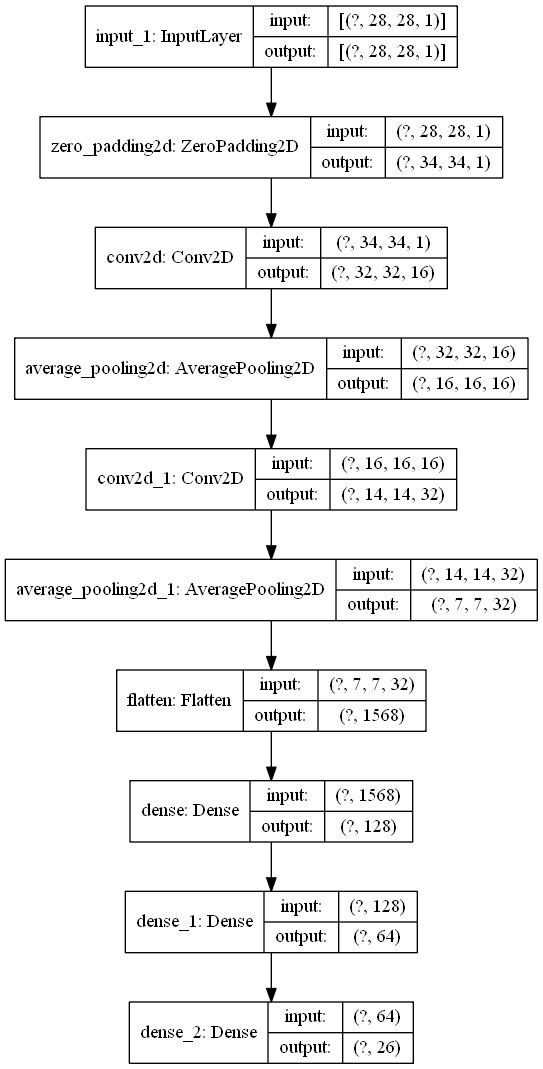

In [6]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [7]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [8]:
history = model.fit(X_train, y_train, 
                        epochs=50,
                        validation_split=0.2)

Train on 21963 samples, validate on 5491 samples
Epoch 1/50
21963/21963 [==============================] - 7s 340us/sample - loss: 3.0659 - accuracy: 0.0957 - val_loss: 2.7603 - val_accuracy: 0.1672
Epoch 2/50
10496/21963 [=============>................] - ETA: 3s - loss: 2.3218 - accuracy: 0.2840

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

plt.show()

NameError: name 'history' is not defined

In [2]:
model.evaluate(X_test, y_test)

NameError: name 'model' is not defined

In [3]:
import math

num_rows = 3
num_cols = 3

X_new = X_test[:num_rows*num_cols]

y_pred = model.predict_classes(X_new)

fig, ax = plt.subplots(num_rows, num_cols)
for index, image in enumerate(X_new):
    ax[math.floor(index/num_rows), index%num_rows].imshow(image.reshape((28,28)))
    ax[math.floor(index/num_rows), index%num_rows].set_title(
        f"Actual: {class_names[y_test[index]]}\nPredicted: {class_names[y_pred[index]]}",
        fontsize=12)
    ax[int(index/num_rows), index%num_rows].axis('off')

fig.tight_layout()
fig.suptitle(f'First Predictions', fontsize=20)
fig.subplots_adjust(top=0.88)
fig.show()

NameError: name 'X_test' is not defined

In [4]:
y_pred = model.predict_classes(X_test)

confusion_indices = np.where(y_pred != y_test)
X_confusion = X_test[confusion_indices]
y_pred_confusion = y_pred[confusion_indices]
y_test_confusion = y_test[confusion_indices]

fig, ax = plt.subplots(num_rows, num_cols)
for index, image in enumerate(X_confusion[:num_rows*num_cols]):
    ax[math.floor(index/num_rows), index%num_rows].imshow(image.reshape((28,28)), interpolation='nearest')
    ax[math.floor(index/num_rows), index%num_rows].set_title(
        f"Actual: {class_names[y_test_confusion[index]]}\nPredicted: {class_names[y_pred_confusion[index]]}",
        fontsize=12)
    ax[int(index/num_rows), index%num_rows].axis('off')


fig.tight_layout()
fig.suptitle('Incorrect Predictions', fontsize=20)
fig.subplots_adjust(top=0.88)
fig.show()

NameError: name 'model' is not defined

In [5]:
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
row_sum = confusion_matrix.sum(axis=1, keepdims=True)
norm_confusion_matrix = confusion_matrix / row_sum

# Becausse j and z aren't possible we cant include them in confusion matrix
class_names_clean = class_names.copy()
class_names_clean.remove('j')
class_names_clean.remove('z')

np.fill_diagonal(norm_confusion_matrix, 0)

mat_ax = plt.matshow(norm_confusion_matrix, interpolation='nearest', cmap=plt.cm.gray)
plt.colorbar(mat_ax)
plt.title('Confusion matrix for characters', fontsize=20)
plt.xlabel('Actual Class', fontsize=12)
plt.ylabel('Predicted Class', fontsize=12)
plt.xticks(ticks=np.arange(0, len(class_names_clean)), labels=class_names_clean)
plt.yticks(ticks=np.arange(0, len(class_names_clean)), labels=class_names_clean)
plt.show()


NameError: name 'y_test' is not defined

In [6]:
model.reset_metrics()
model.save('models/cnn_model_86_8.h5')

NameError: name 'model' is not defined